In [6]:
from time import sleep
from selenium import webdriver
from string import punctuation
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import copy
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


C:\Users\bandi\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1& 2.) Fetching 5000 posts from Edmunds.com luxury forum

In [72]:
driver = webdriver.Chrome('C:/Users/bandi/Desktop/Text Analytics/TA Session/chromedriver_win32/chromedriver')
driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p702')

In [73]:
#Creating empty data frame to store user_id, dates and comments from ~5K users.
comments = pd.DataFrame(columns = ['Date','user_id','comments'])

j = 702
while (j>=1):
    # Running while loop only till we get 5K comments 
    if (len(comments)<5000):
        url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p' + str(j)
        driver.get(url)
        ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
        comment_ids = []
        for i in ids:
            comment_ids.append(i.get_attribute('id'))

        for x in comment_ids:
            #Extract dates from for each user on a page
            user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
            date = user_date.get_attribute('title')

            #Extract user ids from each user on a page
            user_title = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[1]')[0]
            userid = user_title.get_attribute('title') 

            #Extract Message for each user on a page
            user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]')[0]
            comment = user_message.text
            
            #Extracting Block Quote if Present
            block_quote = driver.find_element_by_xpath('//*[@id="' + x + '"]/div/div[3]/div/div[1]')
            block_quote_class = block_quote.find_elements_by_class_name('UserQuote')
            block_text = ''
            if len(block_quote_class)>0:
                block_text = block_quote_class[0].text
            
            #Replacing block quotes
            comment = comment.replace(block_text,"")
            
           #Adding date, userid and comment for each user in a dataframe    
            comments.loc[len(comments)] = [date,userid,comment]
        j=j-1
    else:
        break
        

In [87]:
import copy
comments_copy = copy.deepcopy(comments)

def remove_space(s):
    return s.replace("\n"," ")
comments_copy['comments'] = comments_copy['comments'].apply(remove_space)

comments_copy.to_csv('comments.csv', header=True, sep=',') 

### Cleansing the posts we fetched from Edmunds.com

In [7]:
comments_copy = pd.read_csv('comments.csv')
comments_copy = comments_copy.dropna()
comments_copy.reset_index(inplace  = True)

In [8]:
def removepunc(item):
    for p in punctuation:
        item = item.lstrip().replace(p,'')
    return item

def lowerize(x):
    return x.lower()

comments_copy['comments_clean'] = comments_copy['comments'].apply(removepunc).apply(lowerize)

In [9]:
models = pd.read_csv("models.csv", header = None, names = ['brand','model'], encoding='windows-1252')

In [10]:
models['brand'] = models['brand'].apply(removepunc)

def model_to_brand(s):
    for i in models.index.values:
        s = s.replace(models["model"][i].lower(),models["brand"][i].lower())
    return s
comments_copy['comments_model_replace'] = comments_copy['comments_clean'].apply(model_to_brand)

In [35]:
comments_copy['comments_appear'] = comments_copy['comments_model_replace'].apply(word_tokenize).apply(set).apply(list)

# Remove stop words
stop_words = set(stopwords.words('english'))
def remove_stopwords(s):
    return [w for w in s if not w in stop_words] 
    
comments_copy['final_comments'] =  comments_copy['comments_appear'].apply(remove_stopwords)
#filtered_sentence = [w for w in temp['comments_appear'] if not w in stop_words]

In [36]:
count = []
for i in range(len(comments_copy)):
    count+=comments_copy['final_comments'][i]

In [37]:
from nltk import FreqDist
word_freq = nltk.FreqDist(count)

In [38]:
models_unique = models['brand'].drop_duplicates().tolist()

In [39]:
top_words = word_freq.most_common(500)
top_brands = []
for (key, items) in top_words:
    if key in models_unique:
        model_counts = (key,items)
        top_brands.append(model_counts)        

### 3. Top 10 brands 

In [40]:
top_10_brands_counts = top_brands[:10]
print ('Below are the top 10 brands along with their frequencies\n' , top_10_brands_counts)

Below are the top 10 brands along with their frequencies
 [('bmw', 1435), ('audi', 1246), ('acura', 1170), ('hyundai', 750), ('volkswagen', 653), ('honda', 632), ('mercedes', 450), ('infiniti', 437), ('ford', 429), ('kia', 400)]


## Task A: Calculate lift ratios for associations between brands. Show the brands on a MDS map.

In [41]:
# Fetching the top 10 brands.
top_10_brands =[]
for brand, count in top_10_brands_counts:
    top_10_brands.append(brand)    

In [42]:
new_df = pd.DataFrame(columns = top_10_brands)

def brand_mentioned(item):
    if brand in item:
        return 1
    else:
        return 0
      
for brand in top_10_brands:
    new_df[brand] = comments_copy['final_comments'].apply(brand_mentioned)    

In [119]:
df2=pd.DataFrame(columns = top_10_brands)

for i in range(len(top_10_brands)):
    new_list = []
    for j in range(len(top_10_brands)):
        if (i!=j):
            lift = (((new_df[top_10_brands[i]] + new_df[top_10_brands[j]]) > 1).sum())/(new_df[top_10_brands[j]].sum()*new_df[top_10_brands[i]].sum())
            lift = lift*len(new_df)
            df2.loc[top_10_brands[i],top_10_brands[j]] = lift

In [120]:
print ('Below are the lift ratios between top 10 brands\n')
df2

Below are the lift ratios between top 10 brands



,bmw,audi,acura,hyundai,volkswagen,honda,mercedes,infiniti,ford,kia
bmw,NaN,1.32243,0.946831,0.840715,0.661515,0.90949,2.31467,1.42693,1.22617,0.722852
audi,1.32243,NaN,1.2139,0.700769,2.42074,1.28868,2.10409,1.64338,0.729462,3.03912
acura,0.946831,1.2139,NaN,1.94833,0.844061,1.94703,1.49068,1.4177,0.537816,0.45931
hyundai,0.840715,0.700769,1.94833,NaN,0.612435,0.55896,1.58487,0.442322,0.605939,0.89982
volkswagen,0.661515,2.42074,0.844061,0.612435,NaN,1.09017,1.02072,0.648172,0.785173,5.47364
honda,0.90949,1.28868,1.94703,0.55896,1.09017,NaN,1.35346,4.18116,0.8297,1.02828
mercedes,2.31467,2.10409,1.49068,1.58487,1.02072,1.35346,NaN,2.03366,1.21706,0.860939
infiniti,1.42693,1.64338,1.4177,0.442322,0.648172,4.18116,2.03366,NaN,0.71996,0.600566
ford,1.22617,0.729462,0.537816,0.605939,0.785173,0.8297,1.21706,0.71996,NaN,1.25266
kia,0.722852,3.03912,0.45931,0.89982,5.47364,1.02828,0.860939,0.600566,1.25266,NaN


### MDS plot

In [45]:
dissimilarity_matrix = 1/df2
np.fill_diagonal(dissimilarity_matrix.values, 0)

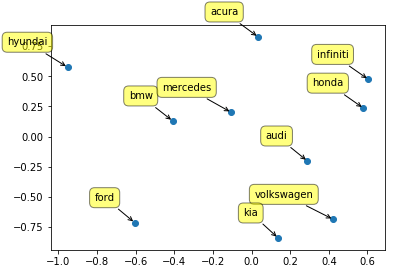

In [46]:
from sklearn import manifold
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)
results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(top_10_brands, coords[:, 0], coords[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

### Task B: What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

### Task C:
### i.) What are 5 most frequently mentioned attributes of cars in the discussions?

In [28]:
attributes = pd.read_csv('attributes.csv')

In [49]:
def word_to_attributes(s):
    s = " ".join(str(x) for x in s)
    for i in attributes.index.values:
        s = s.replace(attributes["Attribute"][i].lower(),attributes["Mapping"][i].lower())
    return s
comments_copy['comments_attributes_replace'] = comments_copy['final_comments'].apply(word_to_attributes)

In [57]:
count = []
for i in range(len(comments_copy)):
    count+=comments_copy['comments_attributes_replace'][i]
attr_freq = nltk.FreqDist(count)
attributes_unique = attributes['Mapping'].drop_duplicates().tolist()

top_words = word_freq.most_common(3000)
top_attributes = []
for (key, items) in top_words:
    if key in attributes_unique:
        attribute_counts = (key,items)
        top_attributes.append(attribute_counts) 

In [71]:
top_5_attributes_counts = top_attributes[:5]
print ('Below are the top 5 attributes along with their frequencies\n' , top_5_attributes_counts)

Below are the top 5 attributes along with their frequencies
 [('performance', 371), ('maintenance', 104), ('styling', 66), ('comfort', 53), ('safety', 47)]


### ii.) Which attributes are most strongly associated with which of the top 5 brands?

In [134]:
# Fetching top 5 attrbutes
top_5_attributes =[]
for attribute, count in top_5_attributes_counts:
    top_5_attributes.append(attribute) 

In [116]:
attributes_df = pd.DataFrame(columns = top_5_attributes)

def attribute_mentioned(item):
    if attribute in item:
        return 1
    else:
        return 0
      
for attribute in top_5_attributes:
    attributes_df[attribute] = comments_copy['comments_attributes_replace'].apply(attribute_mentioned)  

In [131]:
df3=pd.DataFrame(columns = top_5_attributes)

for i in range(len(top_5_brands)):
    new_list = []
    for j in range(len(top_5_attributes)):
        lift_brand_attributes = (((new_df[top_5_brands[i]] + attributes_df[top_5_attributes[j]]) > 1).sum())/(new_df[top_5_brands[i]].sum()*attributes_df[top_5_attributes[j]].sum())
        lift_brand_attributes = lift_brand_attributes*len(attributes_df)
        df3.loc[top_5_brands[i],top_5_attributes[j]] = lift_brand_attributes

In [133]:
print ('Below are the lift ratios between top 5 brands and top 5 attributes \n')
df3

Below are the lift ratios between top 5 brands and top 5 attributes 



,performance,maintenance,styling,comfort,safety
bmw,1.13326,1.34651,1.50113,1.42512,1.24154
audi,1.30649,1.48673,1.81636,1.66798,1.54762
acura,1.50136,1.15149,1.34394,1.35001,1.14654
hyundai,1.0808,0.732714,0.775602,0.908909,0.922247
volkswagen,1.20296,1.42521,1.03,0.984513,1.10739
